In [114]:
%matplotlib inline
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
from functools import reduce
import string
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
from tensorflow.keras.models import model_from_json
np.random.seed(100)
import random


market = [ "AD", "AR", "AT", "AU", "BE", "BG", "BO", "BR", "CA", "CH", "CL", "CO", "CR", "CY", 
      "CZ", "DE", "DK", "DO", "EC", "EE", "ES", "FI", "FR", "GB", "GR", "GT", "HK", "HN", "HU", 
      "ID", "IE", "IS", "IT", "JP", "LI", "LT", "LU", "LV", "MC", "MT", "MX", "MY", "NI", "NL", 
      "NO", "NZ", "PA", "PE", "PH", "PL", "PT", "PY", "SE", "SG", "SK", "SV", "TH", "TR", "TW", 
      "US", "UY", "VN" ]

CLIENT_ID = "bccb28dd24804ecc912efc88806eba38"
CLIENT_SECRET = "e795231413554786934e6a6209106e8d"

credentials = oauth2.SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET)

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

In [115]:
import pickle
with open('playlists.pickle', 'rb') as f:
    playlists = pickle.load(f)

In [116]:
all_songs = pd.DataFrame()
for i, group in enumerate(playlists):
    group['group_id'] = i
all_songs = pd.concat(playlists)
all_songs
all_songs['pid']
all_songs['group_id']
all_songs['unique_id'] = 1000*all_songs['group_id'] + all_songs['pid']
all_songs['playlist_id'] = all_songs['unique_id']


In [117]:
just_songs = all_songs[['track_uri', 'playlist_id', 'artist_name']]
just_songs = just_songs.loc[just_songs['playlist_id'] < 10]

In [118]:
unique_songs = just_songs['track_uri'].unique()
song_index = {song: idx for idx, song in enumerate(unique_songs)}
index_song = {idx: song for song, idx in song_index.items()}

In [119]:
unique_artists = just_songs['artist_name'].unique()
artist_index = {artist: idx for idx, artist in enumerate(unique_artists)}
index_artist = {idx: artist for artist, idx in artist_index.items()}

In [120]:
just_songs['song_index'] = [song_index[song] for song in just_songs['track_uri']]
just_songs['artist_index'] = [artist_index[artist] for artist in just_songs['artist_name']]
just_songs.head()

,track_uri,playlist_id,artist_name,song_index,artist_index
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0,Missy Elliott,0,0
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,0,Britney Spears,1,1
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,0,Beyoncé,2,2
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,0,Justin Timberlake,3,3
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,0,Shaggy,4,4


In [72]:
uris = [track[14:] for track in unique_songs]
n = 100
batches = [uris[i * n:(i + 1) * n] for i in range((len(uris) + n - 1) // n )]
infos = []
for batch in batches:
    infos.append(spotify.audio_features(batch))

In [73]:
with open('infos.pickle', 'wb') as f:
    pickle.dump(infos, f)

# for 1000 playlists (34443 unique songs)
with open('infos.pickle', 'rb') as f:
    infos = pickle.load(f)
infos = [j for i in infos for j in i]


In [74]:
len(unique_songs)
len(infos)

503

In [113]:
features = ["danceability", "energy", "acousticness", "instrumentalness", "valence", "speechiness", "liveness", "tempo", "loudness"]
for feature in features:
    just_songs[feature] = None
for song in unique_songs:
    for track in infos:
        if track['uri'] == song:
            t = track
            song_features = [track[feature] for feature in features]
            break;
    just_songs.loc[just_songs['track_uri'] == song, features] = song_features

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [111]:
with open('just_songs.pickle', 'wb') as f:
    pickle.dump(just_songs, f)

with open('just_songs.pickle', 'rb') as f:
    just_songs = pickle.load(f)

In [112]:
just_songs.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [78]:
unique_song_ids = just_songs['song_index'].unique()
just_songs.shape
unique_song_ids.shape

(503,)

In [16]:
# #pl = just_songs.loc[just_songs['song_index'] == unique_song_ids[0]]['playlist_id']
# predictors = ["artist_index", "danceability", "energy", "acousticness", "instrumentalness", "valence", "speechiness", "liveness", "tempo", "loudness"]
# pairs = []
# song1_feat=[]

# for j in range(len(unique_song_ids)):
#     pl = just_songs.loc[just_songs['song_index']==unique_song_ids[j]]['playlist_id']
#     for i in range(len(predictors)):
#         song1_f = just_songs[just_songs['song_index'] == unique_song_ids[1]][predictors[i]].unique().item()
#         song1_feat.append(song1_f)
#     for p in pl:
#         for _, song2 in just_songs.loc[just_songs['playlist_id'] == p].iterrows():
#             song2_feat = [song2[pred] for pred in predictors]
#             pairs.append(song1_feat + song2_feat)

In [79]:
#took years to run this cell....
#it also gives nans
predictors = ["artist_index", "danceability", "energy", "acousticness", "instrumentalness", "valence", "speechiness", "liveness", "tempo", "loudness"]
pairs = []
for song in unique_song_ids:
    pl = just_songs.loc[just_songs['song_index'] == song]['playlist_id']
    song1_feat = [just_songs[just_songs['song_index'] == song][pred].unique().item() for pred in predictors]
    for p in pl:
        for _, song2 in just_songs.loc[just_songs['playlist_id'] == p].iterrows():
            song2_feat = [song2[pred] for pred in predictors]
            pairs.append(song1_feat + song2_feat)
pairs = np.array(pairs)

In [80]:
with open('pairs.pickle', 'wb') as f:
    pickle.dump(pairs, f)

with open('pairs.pickle', 'rb') as f:
    pairs = pickle.load(f)

In [22]:
pairs_set = set([tuple(i) for i in pairs[:, [0,10]]])

In [23]:
with open('pairs_set.pickle', 'wb') as f:
    pickle.dump(pairs_set, f)
with open('pairs_set.pickle', 'rb') as f:
    pairs_set = pickle.load(f)

In [24]:
pairs_train, pairs_val = train_test_split(pairs, test_size=0.2, random_state=109)

In [45]:
print(pairs_train.shape)
print(pairs_val.shape)
print(pairs.shape)

(29206, 20)
(7302, 20)
(36508, 20)


In [26]:
# why do we use twice as many negative as positive?
def generate_batch(pairs_train, n_positive = 50, n_negative = 100):
    predictors = ["artist_index", "danceability", "energy", "acousticness", "instrumentalness", "valence", "speechiness", "liveness", "tempo", "loudness"]

    """Generate batches of samples for training"""
    batch_size = n_positive + n_negative
    batch = np.zeros((batch_size, 21))
        
    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, pair in zip(range(n_positive), pairs_train[np.random.randint(pairs_train.shape[0], size=n_positive), :]):
            batch[idx, :] = np.append(pair, 1)
        # Increment idx by 1
        idx += 1
        
        # Add negative examples until reach batch size
        while idx < batch_size:
            
            # random selection
            song1 = random.randrange(len(unique_song_ids))
            song2 = random.randrange(len(unique_song_ids))
            
            # Check to make sure this is not a positive example
            if (song1, song2) not in pairs_set:
                
                song1_feat = [just_songs[just_songs['song_index'] == song1][pred].unique().item() for pred in predictors]
                song2_feat = [just_songs[just_songs['song_index'] == song2][pred].unique().item() for pred in predictors]
                
                # Add to batch and increment index
                batch[idx, :] = np.concatenate([song1_feat, np.append(song2_feat, 0)])
                idx += 1
                
        # Make sure to shuffle order
        np.random.shuffle(batch)
        
        d = dict({'song1': batch[:, 0]})
        d.update({feat + '1': batch[:, i+1] for i, feat in enumerate(predictors)})
        d.update({'song2': batch[:, 10]})
        d.update({feat + '2': batch[:, i+10] for i, feat in enumerate(predictors)})

        
        yield  d, batch[:, 20]

In [27]:
next(generate_batch(pairs_train, n_positive = 2, n_negative = 1))

({'song1': array([ 94., 127., 188.]),
  'artist_index1': array([0.361, 0.429, 0.734]),
  'danceability1': array([0.392, 0.816, 0.581]),
  'energy1': array([0.774, 0.313, 0.24 ]),
  'acousticness1': array([0.145   , 0.0255  , 0.000585]),
  'instrumentalness1': array([0.238, 0.436, 0.962]),
  'valence1': array([0.0312, 0.0458, 0.032 ]),
  'speechiness1': array([0.107 , 0.114 , 0.0298]),
  'liveness1': array([130.662, 140.595, 119.337]),
  'tempo1': array([-11.679,  -7.756,  -6.619]),
  'loudness1': array([122.,   7., 176.]),
  'song2': array([122.,   7., 176.]),
  'artist_index2': array([122.,   7., 176.]),
  'danceability2': array([0.35 , 0.771, 0.378]),
  'energy2': array([0.1  , 0.685, 0.896]),
  'acousticness2': array([9.89e-01, 5.43e-03, 4.52e-04]),
  'instrumentalness2': array([0.545  , 0.00157, 0.     ]),
  'valence2': array([0.135, 0.683, 0.469]),
  'speechiness2': array([0.0328, 0.0567, 0.0407]),
  'liveness2': array([0.11  , 0.0537, 0.194 ]),
  'tempo2': array([108.74 ,  88.997

In [55]:
def song_embedding_model(embedding_size = 50):
    
    # All inputs are 1-dimensional
    song1 = Input(name = 'song1', shape = [1])
    song2 = Input(name = 'song2', shape = [1])
    artist1 = Input(name = 'artist_index1', shape = [1])
    artist2 = Input(name = 'artist_index2', shape = [1])
    danceability1 = Input(name = 'danceability1', shape = [1])
    danceability2 = Input(name = 'danceability2', shape = [1])
    energy1 = Input(name = 'energy1', shape = [1])
    energy2 = Input(name = 'energy2', shape = [1])
    acousticness1 = Input(name = 'acousticness1', shape = [1])
    acousticness2 = Input(name = 'acousticness2', shape = [1])
    instrumentalness1 = Input(name = 'instrumentalness1', shape = [1])
    instrumentalness2 = Input(name = 'instrumentalness2', shape = [1])
    valence1 = Input(name = 'valence1', shape = [1])
    valence2 = Input(name = 'valence2', shape = [1])
    speechiness1 = Input(name = 'speechiness1', shape = [1])
    speechiness2 = Input(name = 'speechiness2', shape = [1])
    liveness1 = Input(name = 'liveness1', shape = [1])
    liveness2 = Input(name = 'liveness2', shape = [1])
    tempo1 = Input(name = 'tempo1', shape = [1])
    tempo2 = Input(name = 'tempo2', shape = [1])
    loudness1 = Input(name= 'loudness1', shape = [1])
    loudness2 = Input(name= 'loudness2', shape = [1])
   # predictors1 = Input(name = 'predictors1', shape = [8])
   # predictors2 = Input(name = 'predictors2', shape = [8])
 
    # Embedding song1 (shape will be (None, 1, 50))
    song1_embedding = Embedding(name = 'song1_embedding',
                               input_dim = len(song_index),
                               output_dim = embedding_size)(song1)
    
    # Embedding song2 (shape will be (None, 1, 50))
    song2_embedding = Embedding(name = 'song2_embedding',
                               input_dim = len(song_index),
                               output_dim = embedding_size)(song2)
    
    # Embedding the artist1 (shape will be (None, 1, 50))
    artist1_embedding = Embedding(name = 'artist1_embedding',
                               input_dim = len(artist_index),
                               output_dim = embedding_size)(artist1)
    
    # Embedding the artist2 (shape will be (None, 1, 50))
    artist2_embedding = Embedding(name = 'artist2_embedding',
                               input_dim = len(artist_index),
                               output_dim = embedding_size)(artist2)
        

    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged_song = Dot(name = 'dot_product_song', normalize = True, axes = 2)([song1_embedding, song2_embedding])

    # Reshape to be a single number (shape will be (None, 1))
    merged_song = Reshape(target_shape = [1])(merged_song)
    
    merged_artist = Dot(name = 'dot_product_artist', normalize = True, axes = 2)([artist1_embedding, artist2_embedding])
    
    # Reshape to be a single number (shape will be (None, 1))
    merged_artist = Reshape(target_shape = [1])(merged_artist)
     
    #concatenate = Concatenate()([merged_song, merged_artist, predictors1, predictors2])
    concatenate = Concatenate()([merged_song, merged_artist, danceability1, danceability2, energy1,energy2,
                                 acousticness1, acousticness2, instrumentalness1, instrumentalness2, valence1, 
                                valence2, speechiness1, speechiness2, liveness1, liveness2, tempo1, tempo2, 
                                loudness1, loudness2])
    output = Dense(1, activation = 'sigmoid')(concatenate)



    
    model = Model(inputs = [song1, song2, artist1, artist2,  danceability1, danceability2, energy1,energy2,
                                 acousticness1, acousticness2, instrumentalness1, instrumentalness2, valence1, 
                                valence2, speechiness1, speechiness2, liveness1, liveness2, tempo1, tempo2, 
                                loudness1, loudness2], outputs = output)
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        
    return model

# Instantiate model and show parameters
model = song_embedding_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
song1 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
song2 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
artist_index1 (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
artist_index2 (InputLayer)      [(None, 1)]          0                                            
____________________________________________________________________________________________

In [90]:
# we ran this in google colab gpu
# n_positive = 10
# n_negative = 20
# gen = generate_batch(pairs_train, n_positive, n_negative)
# gen_val = generate_batch(pairs_val, n_positive, n_negative)
# # Train
# h = model.fit_generator(gen, epochs = 5, 
#                         steps_per_epoch = len(pairs) // n_positive, validation_data = gen_val,
#                         verbose = 2)

In [94]:
#saved model
json_file = open('model.json', 'r')

# Model reconstruction from JSON file
with open('model.json', 'r') as f:
    model = model_from_json(f.read())
song1_layer = model.get_layer('song1_embedding')
song1_weights = song1_layer.get_weights()[0]
song1_weights.shape

(503, 50)

In [84]:
#saved song weights
with open('song1_weights.pickle', 'rb') as f:
    song1_weights = pickle.load(f)

In [85]:
song1_weights = song1_weights / np.linalg.norm(song1_weights, axis = 1).reshape((-1, 1))
song1_weights[0][:10]
np.sum(np.square(song1_weights[0]))

0.9999998

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'song', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""
    
    # Select index and reverse index
    if index_name == 'song':
        index = song_index
        rindex = index_song
    elif index_name == 'song2':
        index = song_index
        rindex = index_song
    
    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return
    
    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)
    
    # Plot results if specified
    if plot:
        
        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)
        
        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)
        
        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))
        
        data = pd.DataFrame({'distance': distances}, index = items)
        
        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');
        
        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]
         
        print(f'{index_name.capitalize()}s furthest from {name}.\n')
        
    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]
        
        # Need distances later on
        if return_dist:
            return dists, closest
        
        
        #print(f'{index_name.capitalize()}s closest to {name}.\n')
        
    # Need distances later on
    if return_dist:
        return dists, closest
    
    
    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])
    song_name = []
    similarity = []
    # Print the most similar and distances
    for c in reversed(closest):
        song_name.append(rindex[c])
        similarity.append(dists[c])
      #  print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')
    return song_name, similarity

In [87]:
song_uri_list, similarity_list = find_similar('spotify:track:6I9VzXrHxO9rA9A5euc8Ak', song1_weights)
unique_song_list = []
for song in song_uri_list: 
    unique_song_list.append(all_songs.track_name.loc[all_songs.track_uri == song].drop_duplicates(
        keep='first').tolist())

In [88]:
similar_song_list = [item for sublist in unique_song_list for item in sublist]
song_df = pd.DataFrame({'Similarity': similarity_list})
song_df['Suggested Song'] = similar_song_list
#song_df = pd.DataFrame([[similarity_list]], columns = ['Similarity'])

In [89]:
song_df

,Similarity,Suggested Song
0,1.000000,Toxic
1,0.949364,Buttons
2,0.948898,"Jumpin', Jumpin'"
3,0.948502,Year 3000
4,0.944994,Right Where You Want Me - Radio Edit Version
5,0.940854,It Wasn't Me
6,0.938565,Lose Control (feat. Ciara & Fat Man Scoop)
7,0.938363,Just The Girl
8,0.929404,Check On It - feat. Bun B and Slim Thug
9,0.925899,Beautiful Soul


In [98]:
with open('loss_val.pickle', 'rb') as f:
    loss_val = pickle.load(f)
with open('loss_train.pickle', 'rb') as f:
    loss_train = pickle.load(f)
with open('accuracy_val.pickle', 'rb') as f:
    acc_val = pickle.load(f)
with open('accuracy_train.pickle', 'rb') as f:
    acc_train = pickle.load(f)

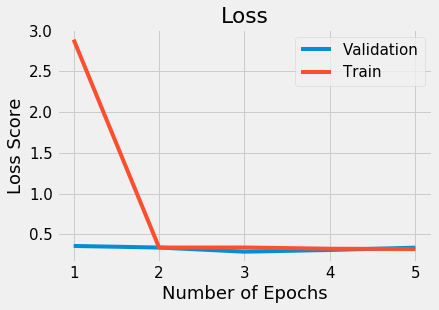

In [108]:
epoch = [1,2,3,4,5]
plt.plot(epoch, loss_val, label = 'Validation')
plt.plot(epoch, loss_train, label = 'Train')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Score')
plt.title('Loss')
plt.legend()

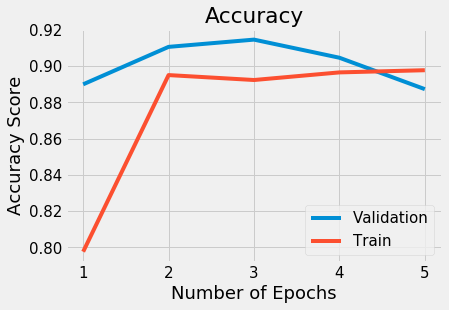

In [107]:
plt.plot(epoch, acc_val, label = 'Validation')
plt.plot(epoch, acc_train, label = 'Train')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Score')
plt.title('Accuracy')
plt.legend()

In [123]:
#choose random song and choose the next closest song to whatever
import itertools as iter
df2 = just_songs.groupby('playlist_id').track_uri.apply(lambda x: list(iter.combinations(x, 2)))

In [126]:
# for each playlist match every song with every other song in the playlist
# in theory we could calculate how similar the songs are
df2.head()

playlist_id
0    [(spotify:track:0UaMYEvWZi0ZqiDOoHU3YI, spotif...
1    [(spotify:track:2HHtWyy5CgaQbC7XSoOb0e, spotif...
2    [(spotify:track:74tqql9zP6JjF5hjkHHUXp, spotif...
3    [(spotify:track:4WJ7UMD4i6DOPzyXU5pZSz, spotif...
4    [(spotify:track:4iCGSi1RonREsPtfEKYj5b, spotif...
Name: track_uri, dtype: object

In [ ]:
# info = spotify.audio_features(rand_ids)
# features = ["danceability", "energy", "acousticness", "instrumentalness", "valence", "speechiness", "liveness", "tempo", "loudness"]
# fig, axs = plt.subplots(3,3, figsize = (20,20))
# for i, ax in enumerate(axs.ravel()):
#     ax.scatter(np.arange(0, 29), [track[features[i]] for track in info])
#     ax.set_title(features[i])
#     ax.set_xlabel("Song Index")
#     ax.set_ylabel('Score')
# fig.tight_layout()